<a href="https://colab.research.google.com/github/vamshikumar20/Classification_of_thyroid-cancer-using-ensemble-cnn-algorithm./blob/master/NewMajorProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install keras --upgrade


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install tensorflow --upgrade


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import json
import math
import os

import cv2
from keras.optimizers import  Adam
from PIL import Image
import numpy as np
from keras import layers
from keras.applications.resnet import ResNet50
from keras.applications.mobilenet import MobileNet
from keras.applications.densenet import DenseNet201
from keras.applications.inception_v3 import InceptionV3
from keras.applications.nasnet import NASNetLarge
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.nasnet import  NASNetMobile
from keras.layers import Dense, Activation, Flatten
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
# !pip install adam_v2,Adam

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools


%matplotlib inline

In [ ]:

!pip install gradio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.7/19.7 MB 65.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 72.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.4/288.4 kB 30.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.0/137.0 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 k

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        # if ftype == ".png":
        img = read(PATH)

        img = cv2.resize(img, (RESIZE,RESIZE))
        IMG.append(np.array(img))
    # print(IMG)
    return IMG

benign_train = np.array(Dataset_loader('/content/drive/MyDrive/Programs/Datasets/train/benin',224))
malign_train = np.array(Dataset_loader('/content/drive/MyDrive/Programs/Datasets/train/malignant',224))
benign_test = np.array(Dataset_loader('/content/drive/MyDrive/Programs/Datasets/test/benin',224))
malign_test = np.array(Dataset_loader('/content/drive/MyDrive/Programs/Datasets/test/malignan',224))

100%|██████████| 51/51 [00:12<00:00,  4.25it/s]


In [ ]:
# Thyroid Cancer: Malignant vs. Benign
# Create labels
benign_train_label = np.zeros(len(benign_train))
malign_train_label = np.ones(len(malign_train))
benign_test_label = np.zeros(len(benign_test))
malign_test_label = np.ones(len(malign_test))

# Merge data
X_train = np.concatenate((benign_train, malign_train), axis = 0)
Y_train = np.concatenate((benign_train_label, malign_train_label), axis = 0)
X_test = np.concatenate((benign_test, malign_test), axis = 0)
Y_test = np.concatenate((benign_test_label, malign_test_label), axis = 0)

# Shuffle train data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

# Shuffle test data
s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

# To categorical
Y_train = to_categorical(Y_train, num_classes= 2)
Y_test = to_categorical(Y_test, num_classes= 2)

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train,
    test_size=0.2,
    random_state=11
)

In [ ]:
class_names=['malignant','benign']

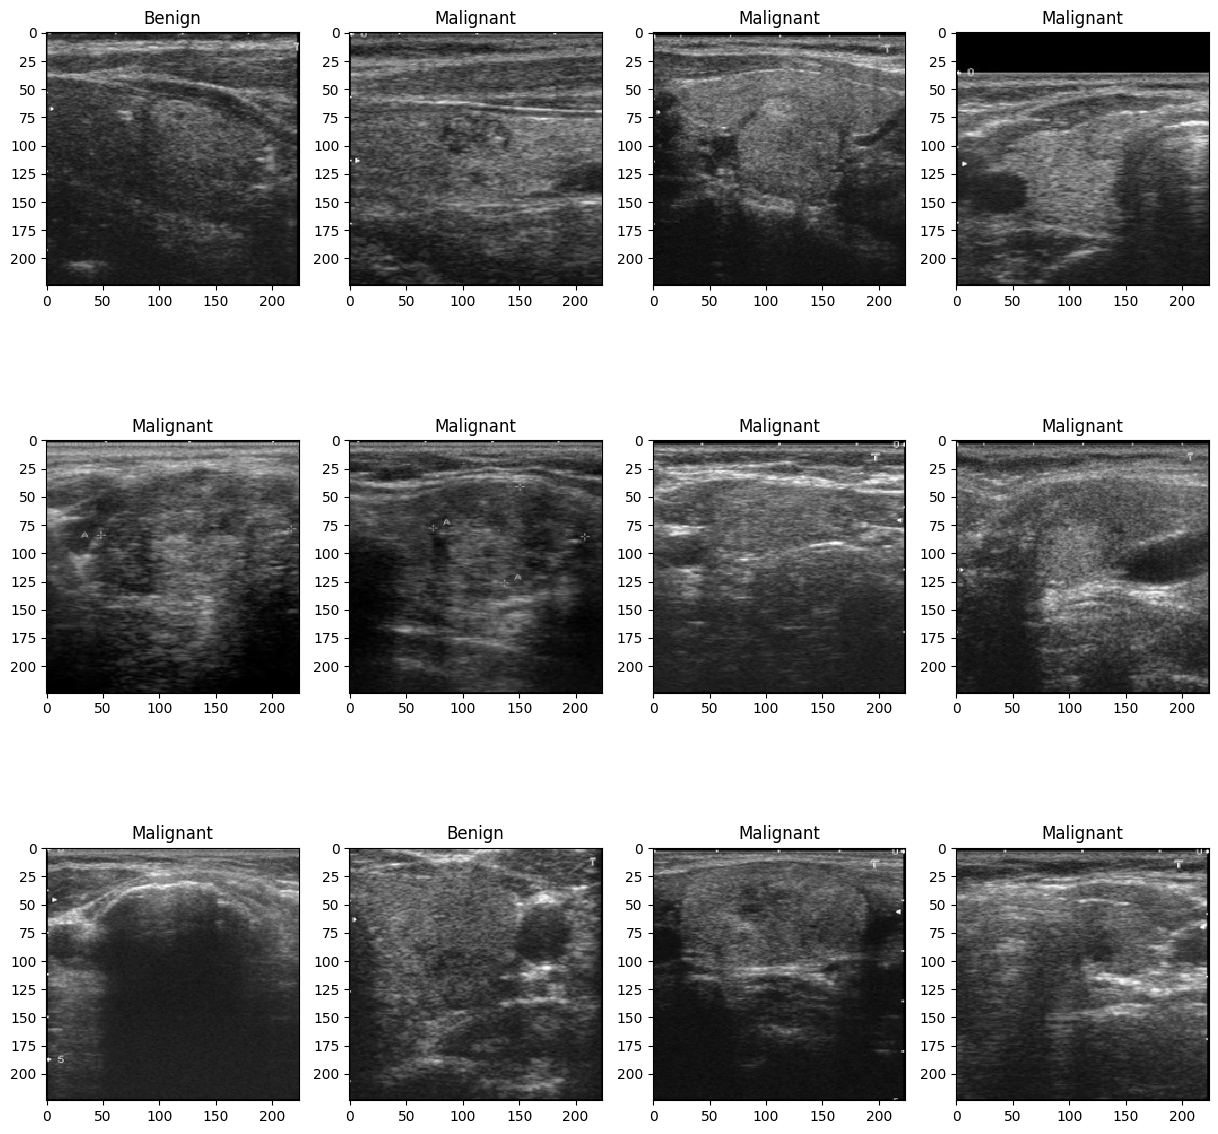

In [ ]:

# # Display first 12 images of moles, and how they are classified
w=60
h=40
fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if np.argmax(y_train[i]) == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(x_train[i], interpolation='nearest')
plt.show()

In [ ]:
BATCH_SIZE = 32
# re-size all the images to this
IMAGE_SIZE = [224, 224]
# Using original generator
train_generator = ImageDataGenerator(
        zoom_range=2,  # set range for random zoom
        rotation_range = 90,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
    )

In [ ]:
from tensorflow.keras.models import Model, load_model

def build_model(backbone, lr=1e-4):
    model = Sequential()
    model.add(backbone)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())

    model.add(layers.Dense(2, activation='softmax'))


    load_model('/content/drive/MyDrive/Colab Notebooks/cnn_model.h5')

    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=lr),
        metrics=['accuracy']
    )
    # model1.load_weights("weights.best.hdf5")

    return model

In [ ]:
K.clear_session()
gc.collect()

resnet = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)
# model1 = build_model(resnet ,lr= 1e-4)
model1=load_model('/content/drive/MyDrive/Colab Notebooks/cnn_model.h5')
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 batch_normalization (BatchN  (None, 2048)             8192      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 2)                 4098      
                                                                 
Total params: 23,600,002
Trainable params: 23,542,786
No

In [ ]:
from keras import callbacks
earlystopping = callbacks.EarlyStopping(monitor="val_loss",
                                        mode="min", patience=5,
                                        restore_best_weights=True)

history = model1.fit(x_train,y_train,batch_size=16,
                    epochs=50, validation_data=(x_val,y_val),
                    callbacks=[earlystopping])

Epoch 1/50
26/26 [==============================] - 14s 222ms/step - loss: 0.4838 - accuracy: 0.8202 - val_loss: 0.3590 - val_accuracy: 0.8725
Epoch 2/50
26/26 [==============================] - 5s 176ms/step - loss: 0.2068 - accuracy: 0.9335 - val_loss: 0.3610 - val_accuracy: 0.8824
Epoch 3/50
26/26 [==============================] - 5s 179ms/step - loss: 0.0944 - accuracy: 0.9803 - val_loss: 0.3578 - val_accuracy: 0.8725
Epoch 4/50
26/26 [==============================] - 4s 173ms/step - loss: 0.0661 - accuracy: 0.9852 - val_loss: 0.4393 - val_accuracy: 0.8922
Epoch 5/50
26/26 [==============================] - 5s 189ms/step - loss: 0.0467 - accuracy: 0.9926 - val_loss: 0.4316 - val_accuracy: 0.8333
Epoch 6/50
26/26 [==============================] - 5s 175ms/step - loss: 0.0593 - accuracy: 0.9828 - val_loss: 0.5775 - val_accuracy: 0.8725
Epoch 7/50
26/26 [==============================] - 5s 174ms/step - loss: 0.0301 - accuracy: 0.9901 - val_loss: 0.9768 - val_accuracy: 0.8922
Epoch

In [ ]:
with open('history.json', 'w') as f:
    json.dump(str(history.history), f)

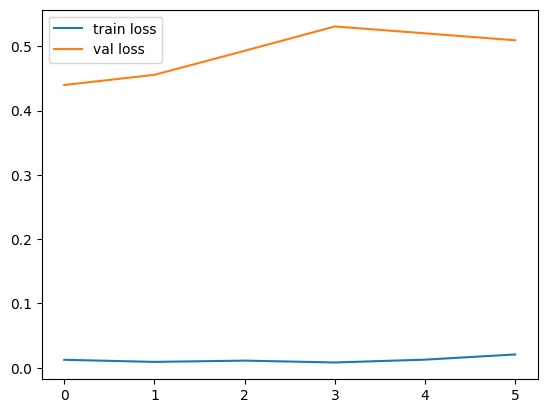

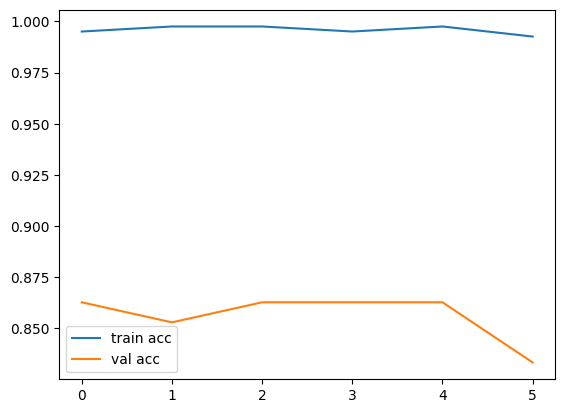

<Figure size 640x480 with 0 Axes>

In [ ]:
# plot the loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [ ]:
# save it as a hdf5 file
model1.save('weights.best.hdf5')

In [ ]:
model1.load_weights("weights.best.hdf5")

In [ ]:
Y_val_pred = model1.predict(x_val)

4/4 [==============================] - 0s 100ms/step


In [ ]:
accuracy_score(np.argmax(y_val, axis=1), np.argmax(Y_val_pred, axis=1))

0.8725490196078431

In [ ]:
import tensorflow
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

## Loading VGG16 model
K.clear_session()
gc.collect()

VGG= VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)

model2= build_model(VGG ,lr= 1e-4)
model2.summary()

58889256/58889256 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 2)                 1026      
                                                         

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
# 2 model
# Learning Rate Reducer
learn_control = ReduceLROnPlateau(monitor='val_acc', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)

# Checkpoint
filepath="2modelweights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [ ]:
# history2 = model2.fit(
#     train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
#     steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
#     epochs=10,
#     validation_data=(x_val, y_val)
# )

from keras import callbacks
earlystopping = callbacks.EarlyStopping(monitor="val_loss",
                                        mode="min", patience=5,
                                        restore_best_weights=True)



history2= model2.fit(x_train,y_train,batch_size=64,
                    epochs=25, validation_data=(x_val,y_val),
                    callbacks=[earlystopping])

Epoch 1/25
7/7 [==============================] - 42s 3s/step - loss: 0.6395 - accuracy: 0.7167 - val_loss: 0.5513 - val_accuracy: 0.7059
Epoch 2/25
7/7 [==============================] - 6s 802ms/step - loss: 0.4521 - accuracy: 0.8547 - val_loss: 0.7070 - val_accuracy: 0.7843
Epoch 3/25
7/7 [==============================] - 6s 803ms/step - loss: 0.3940 - accuracy: 0.8719 - val_loss: 0.7553 - val_accuracy: 0.5490
Epoch 4/25
7/7 [==============================] - 5s 771ms/step - loss: 0.3827 - accuracy: 0.8719 - val_loss: 0.5420 - val_accuracy: 0.8824
Epoch 5/25
7/7 [==============================] - 6s 815ms/step - loss: 0.3357 - accuracy: 0.8867 - val_loss: 0.3807 - val_accuracy: 0.9216
Epoch 6/25
7/7 [==============================] - 5s 778ms/step - loss: 0.3380 - accuracy: 0.8916 - val_loss: 0.3287 - val_accuracy: 0.9216
Epoch 7/25
7/7 [==============================] - 6s 823ms/step - loss: 0.2859 - accuracy: 0.8916 - val_loss: 0.3042 - val_accuracy: 0.9216
Epoch 8/25
7/7 [======

In [ ]:
with open('history2.json', 'w') as f:
    json.dump(str(history2.history), f)

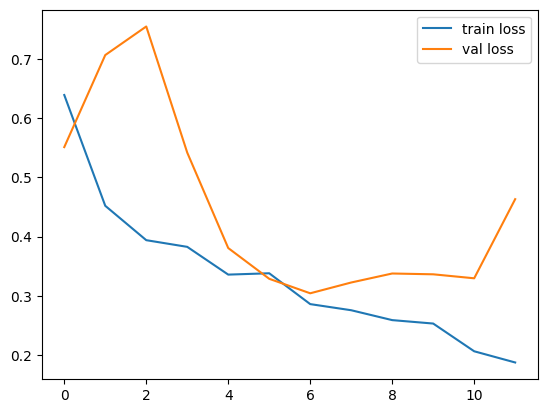

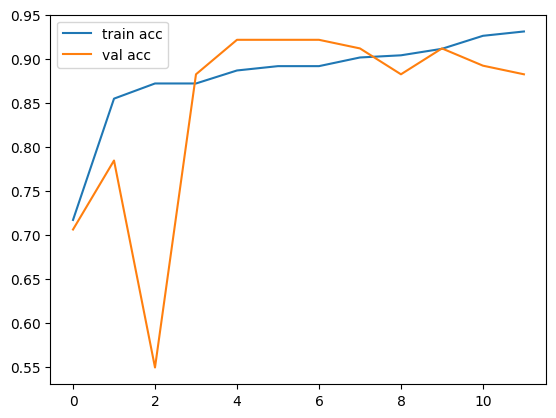

<Figure size 640x480 with 0 Axes>

In [ ]:
# plot the loss
plt.plot(history2.history['loss'], label='train loss')
plt.plot(history2.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss2')

# plot the accuracy
plt.plot(history2.history['accuracy'], label='train acc')
plt.plot(history2.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc2')

In [ ]:
# save it as a hdf5 file
model2.save('2modelweights.best.hdf5')

In [ ]:
model2.load_weights("2modelweights.best.hdf5")

In [ ]:
Y_val_pred2 = model2.predict(x_val)

4/4 [==============================] - 6s 464ms/step


In [ ]:
accuracy_score(np.argmax(y_val, axis=1), np.argmax(Y_val_pred2, axis=1))

0.9215686274509803

In [ ]:
# creating ensemble model

In [ ]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Average
model_1 = load_model('/content/drive/MyDrive/Colab Notebooks/weights.best (1).hdf5')
model_1 = Model(inputs=model_1.inputs,
                outputs=model_1.outputs,
                name='name_of_model_1')

model_2 = load_model('/content/drive/MyDrive/Colab Notebooks/weights.best (1).hdf5')
model_2 = Model(inputs=model_2.inputs,
                outputs=model_2.outputs,
                name='name_of_model_2')
models = [model_1, model_2]
model_input = Input(shape=(224, 224, 3))
model_outputs = [model(model_input) for model in models]
ensemble_output = Average()(model_outputs)
ensemble_model = Model(inputs=model_input, outputs=ensemble_output, name='ensemble')

In [ ]:
ensemble_model.compile(optimizer='adam',loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

In [ ]:
# from keras import losses
# from keras import optimizers
# from keras import metrics

# ensemble_model.compile(loss = 'mean_squared_error',
#    optimizer = 'sgd', metrics = [metrics.categorical_accuracy])

In [ ]:
ensemble_model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=1e-4),
        metrics=['accuracy']
    )

In [ ]:
ensemble_model.summary()

Model: "ensemble"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 name_of_model_1 (Functional)   (None, 2)            23600002    ['input_4[0][0]']                
                                                                                                  
 name_of_model_2 (Functional)   (None, 2)            23600002    ['input_4[0][0]']                
                                                                                                  
 average (Average)              (None, 2)            0           ['name_of_model_1[0][0]', 

In [ ]:
# Learning Rate Reducer
learn_control = ReduceLROnPlateau(monitor='val_acc', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)

# Checkpoint
filepath="ensembleweights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [ ]:
from keras import callbacks
earlystopping = callbacks.EarlyStopping(monitor="val_loss",
                                        mode="min", patience=2,
                                        restore_best_weights=True)



history3= ensemble_model.fit(x_train,y_train,batch_size=32,
                    epochs=50, validation_data=(x_val,y_val),
                    callbacks=[earlystopping])

Epoch 1/50
13/13 [==============================] - 9s 669ms/step - loss: 0.0208 - accuracy: 0.9975 - val_loss: 0.6511 - val_accuracy: 0.9020
Epoch 2/50
13/13 [==============================] - 8s 633ms/step - loss: 0.0138 - accuracy: 0.9901 - val_loss: 0.6924 - val_accuracy: 0.9020
Epoch 3/50
13/13 [==============================] - 8s 659ms/step - loss: 0.0095 - accuracy: 0.9926 - val_loss: 0.7092 - val_accuracy: 0.8922


In [ ]:

Y_val_pred3 = ensemble_model.predict(x_val)

4/4 [==============================] - 4s 185ms/step


In [ ]:
from sklearn.metrics import confusion_matrix
# from sklearn.metrics import plot_confusion_matrix
cm = confusion_matrix(np.argmax(y_val, axis=1), np.argmax(Y_val_pred3, axis=1))

cm_plot_label =['benign', 'malignant']
# sklearn.metrics.plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Metrix for Skin Cancer')

In [ ]:
print("Ensemble Model Validation Accuracy is {}%".format(((cm[0][0] + cm[1][1])/cm.sum())*100))

Ensemble Model Validation Accuracy is 90.19607843137256%


In [ ]:
print("Ensemble Model Training Accuracy is {}".format(((cm[0][1])/cm.sum())*100))

Ensemble Model Training Accuracy is 0.9803921568627451


In [ ]:
with open('history3.json', 'w') as f:
    json.dump(str(history3.history), f)

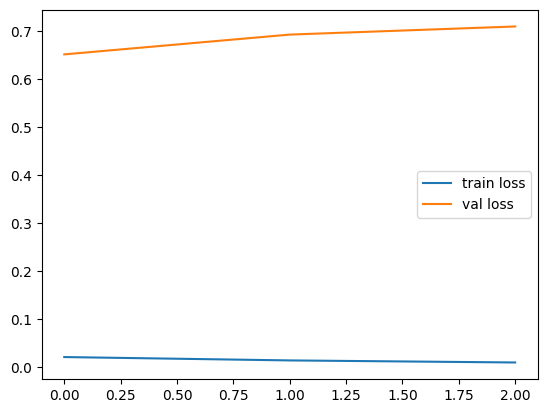

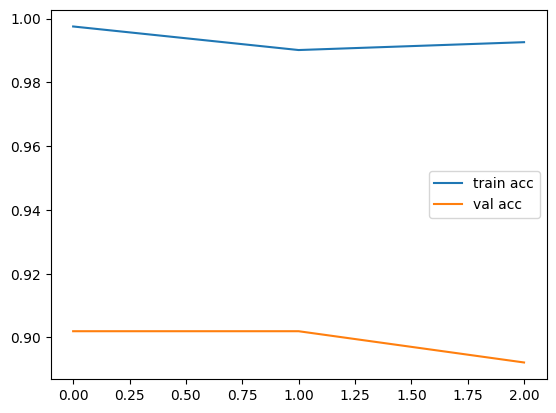

<Figure size 640x480 with 0 Axes>

In [ ]:
# plot the loss
plt.plot(history3.history['loss'], label='train loss')
plt.plot(history3.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss3')

# plot the accuracy
plt.plot(history3.history['accuracy'], label='train acc')
plt.plot(history3.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc3')

In [ ]:
Y_val_pred3 = ensemble_model.predict(x_val)

4/4 [==============================] - 40s 9s/step


In [ ]:
accuracy_score(np.argmax(y_val, axis=1), np.argmax(Y_val_pred3, axis=1))

In [ ]:
tta_steps = 10
predictions = []

for i in tqdm(range(tta_steps)):
    preds = ensemble_model.predict(train_generator.flow(X_test, batch_size=BATCH_SIZE, shuffle=False),
                                    steps = len(X_test)/BATCH_SIZE)

    predictions.append(preds)
    gc.collect()

Y_pred_tta = np.mean(predictions, axis=0)

  0%|          | 0/10 [00:00<?, ?it/s]

3/3 [==============================] - 4s 677ms/step 


 10%|█         | 1/10 [00:05<00:45,  5.02s/it]

3/3 [==============================] - 2s 852ms/step 


 20%|██        | 2/10 [00:08<00:31,  3.98s/it]

3/3 [==============================] - 2s 451ms/step 


 30%|███       | 3/10 [00:11<00:25,  3.61s/it]

3/3 [==============================] - 1s 440ms/step 


 40%|████      | 4/10 [00:13<00:18,  3.02s/it]

3/3 [==============================] - 2s 586ms/step 


 50%|█████     | 5/10 [00:16<00:14,  2.83s/it]

3/3 [==============================] - 2s 648ms/step 


 60%|██████    | 6/10 [00:19<00:12,  3.10s/it]

3/3 [==============================] - 1s 434ms/step 


 70%|███████   | 7/10 [00:21<00:08,  2.76s/it]

3/3 [==============================] - 1s 449ms/step 


 80%|████████  | 8/10 [00:23<00:05,  2.56s/it]

3/3 [==============================] - 1s 442ms/step 


 90%|█████████ | 9/10 [00:25<00:02,  2.41s/it]

3/3 [==============================] - 1s 429ms/step 


100%|██████████| 10/10 [00:27<00:00,  2.80s/it]


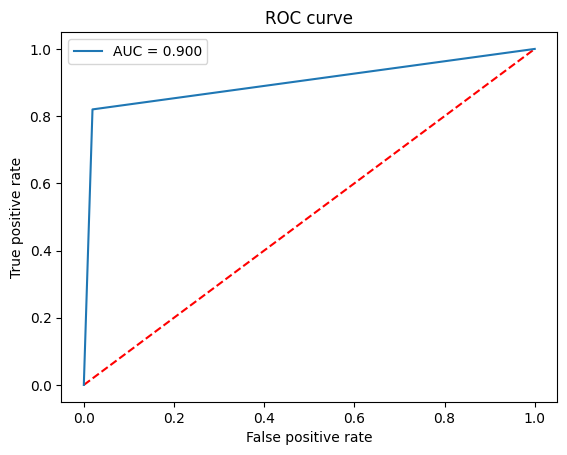

In [ ]:
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import roc_curve
roc_log = roc_auc_score(np.argmax(y_val, axis=1), np.argmax(Y_val_pred3, axis=1))
false_positive_rate, true_positive_rate, threshold = roc_curve(np.argmax(y_val, axis=1), np.argmax(Y_val_pred3, axis=1))
area_under_curve = auc(false_positive_rate, true_positive_rate)

plt.plot([0, 1], [0, 1], 'r--')
plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
#plt.savefig(ROC_PLOT_FILE, bbox_inches='tight')
plt.close()


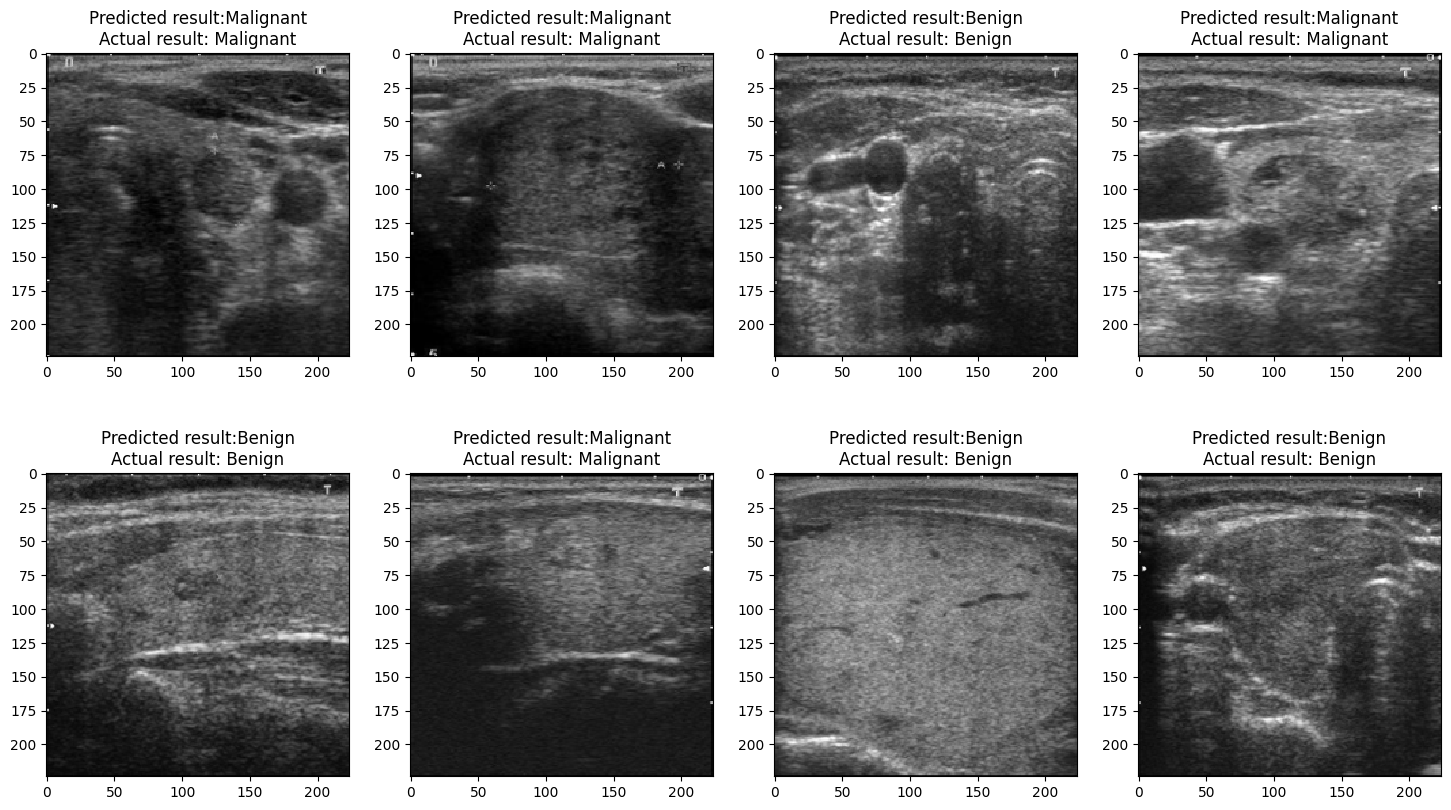

In [ ]:
i=0
prop_class=[]
mis_class=[]

for i in range(len(Y_test[8:])):
    if(np.argmax(Y_test[i])==np.argmax(Y_pred_tta[i])):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(Y_test[8:])):
    if(not np.argmax(Y_test[i])==np.argmax(Y_pred_tta[i])):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

# #
w=60
h=40
fig=plt.figure(figsize=(18, 10))
columns = 4
rows = 2

def Transfername(namecode):
    if namecode==0:
        return "Benign"
    else:
        return "Malignant"

for i in range(len(prop_class)):
    ax = fig.add_subplot(rows, columns, i+1)
    ax.set_title("Predicted result:"+ Transfername(np.argmax(Y_pred_tta[prop_class[i]]))
                       +"\n"+"Actual result: "+ Transfername(np.argmax(Y_test[prop_class[i]])))
    plt.imshow(X_test[prop_class[i]], interpolation='nearest')
# print(prop_class)
plt.show()

In [ ]:
def predict_image(img):
  img_4d=img.reshape(-1,180,180,3)
  prediction=ensemble_model.predict(img_4d)[0]
  print(prediction)
  return {class_names[i]: float(prediction[i]) for i in range(2)}

In [ ]:
import gradio as gr

image = gr.inputs.Image(shape=(180,180))
label = gr.outputs.Label(num_top_classes=1)
# label=gr.Textbox(label="output")
print(label)


label


/usr/local/lib/python3.10/dist-packages/gradio/inputs.py:259: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gradio/inputs.py:262: UserWarning: `optional` parameter is deprecated, and it has no effect
  super().__init__(
/usr/local/lib/python3.10/dist-packages/gradio/outputs.py:197: UserWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gradio/outputs.py:200: UserWarning: The 'type' parameter has been deprecated. Use the Number component instead.
  super().__init__(num_top_classes=num_top_classes, type=type, label=label)


In [ ]:

gr.Interface(fn=predict_image, inputs=image, outputs=label,interpretation='default').launch(debug='True',share='True')

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://3a34911ee5cbb89a54.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
